## Extracting Structured Data from Fashion Images with Grok: 🤖 + 🤵‍♂️ &rarr; 📄

Imagine this: You’re running an online clothing store. New inventory drop, 1,000 fresh pieces, from sleek suits to cozy sweaters. Your team’s pumped… until the tagging nightmare begins. Someone’s got to eyeball every single image, jot down “black pinstripe suit” or “red polka-dot dress,” and pray they don’t mix up “navy” with “midnight blue.” It’s meticulous, it’s time-consuming, and it’s expensive.

#### Why is tagging/metadata extraction from images important?
Why bother with tagging? It comes down to basics: tags are what make online retail work smoothly. Customers search "black suit" or "polka-dot dress" and expect instant, relevant results right away. No tags? They won’t find what they’re after. Inconsistent tags? They might just drift to a competitor. Skip them, and it’s not just time that slips away; sales, relevance, and customer goodwill can take a hit too. Tagging isn’t just a nice-to-have, it’s a must-have.

Now picture the flip side: What if you could process those images with AI and get clean, structured data like this, in seconds? 
```json
{ "gender": "male", "clothing_type": "suit", "color": "black", "pattern": "pin-stripe" }  
```
Fully automated, fast, and smart, that’s where Grok steps in. xAI’s multi-modal powerhouse, equipped with vision and language capabilities, perfect for the task of extracting structured data from images.

In this cookbook, we’re cracking open the [Clothing Attributes Dataset](https://www.kaggle.com/datasets/mahdiehhajian/clothing-attributes-dataset) and unleashing Grok to do the heavy lifting. By the end, you’ll see how you can automate the process of structured data extraction from images, measure performance and even customize the data you extract.

## Table of Contents

- [Exploring the Dataset](#exploring-the-dataset)
- [A Quick Recap on the Image Understanding API](#a-quick-recap-on-the-image-understanding-api)
- [Structured Data Extraction](#structured-data-extraction)
- [Evals](#evals)
  - [Using the Async API to Batch Process Images](#using-the-async-api-to-batch-process-images)
  - [Calculating our Evaluation Metrics](#calculating-our-evaluation-metrics)
  - [Error Analysis and Looking at our Data](#error-analysis-and-looking-at-our-data)
- [Custom Schema Parsing with Pydantic and the Structured Outputs API](#custom-schema-parsing-with-pydantic-and-the-structured-outputs-api)
- [Conclusion](#conclusion)

### Exploring the Dataset <a name="exploring-the-dataset"></a>
The dataset we are using is the Clothing Attributes Dataset, an open-source collection of over 1,000 images of humans in various fashion outfits, freely available on [kaggle](https://www.kaggle.com/datasets/mahdiehhajian/clothing-attributes-dataset). Accompanying the images are ground truth labels describing the attributes present in each image. The original dataset provides these attributes as matrices, but we’ve transformed them into JSON for easier use in this cookbook.

As highlighted in the dataset's [README](https://www.kaggle.com/datasets/mahdiehhajian/clothing-attributes-dataset), the ground truth attributes were obtained via the use of six, paid human labelers. For certain attributes, the ground truth label is "unknown", meaning the six human labelers could not reach an agreement on that attribute.

In [53]:
%pip install --quiet IPython openai matplotlib numpy pandas scikit-learn pydantic seaborn tqdm python-dotenv

Note: you may need to restart the kernel to use updated packages.


Let's take a look at a sample image and its accompanying ground truth attributes, you can change the input to the function below to explore different image, attribute pairs to get a feel for the data we're dealing with.

In [54]:
import json


IMAGES_DIR = "data/images"
LABELS_DIR = "data/labels"

with open(f"{LABELS_DIR}/ground_truth_attributes.json") as f:
    ground_truth_attributes = json.load(f)

def get_gt_attributes_by_id(image_id: str) -> dict[str, str]:
    return ground_truth_attributes[int(image_id) - 1] # image_ids start from 1

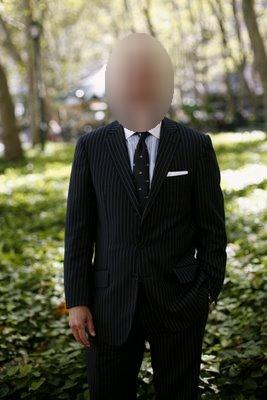

{
  "image_id": "000001",
  "necktie": "yes",
  "collar": "yes",
  "gender": "male",
  "placket": "yes",
  "skin_exposure": "low_exposure",
  "scarf": "no",
  "solid_pattern": "unknown",
  "floral_pattern": "no",
  "spot_pattern": "unknown",
  "graphics_pattern": "no",
  "plaid_pattern": "no",
  "stripe_pattern": "unknown",
  "red": "no",
  "yellow": "no",
  "green": "no",
  "cyan": "no",
  "blue": "no",
  "purple": "no",
  "brown": "no",
  "white": "no",
  "gray": "no",
  "black": "yes",
  "many_colors": "no",
  "sleeve_length": "long_sleeves",
  "neckline": "v_shape",
  "category": "suit"
}

In [55]:
import json

from IPython.display import Code, Image, display


def show_image_and_attributes(image_id="000001"):
    image_path = f"{IMAGES_DIR}/{image_id}.jpg"

    img = Image(image_path)

    attributes = get_gt_attributes_by_id(image_id)
    pretty_json = json.dumps(attributes, indent=2)

    display(img)
    display(Code(pretty_json, language='json'))


show_image_and_attributes("000001")

Here we can see that the dataset contains a variety of different attributes describing the colors present in the photo, the patterns, and structural features like collars and plackets. If this were an e-commerce application, these would power things like search, filtering, and inventory categorization.

We will use Grok to automate the extraction of these attributes for a given a photo.
Furthermore, because this dataset contains ground truth attributes, we can run evaluations (evals) on our approach to understand the performance of our system. Additionally, these evals can illuminate discrepancies between expected and actual results, serving as a diagnostic tool. This enables targeted investigations into unexpected outcomes, allowing us to systematically refine our approach rather than relying on guesswork.

One thing you may notice, especially with photos containing more complex outfits, is that the attributes/schema is quite simplistic and ambiguous. For example, the color and pattern attributes here don't specify which items they're referring to. It could also be the case that within the same photo, different items of clothing possess different colors and patterns.

But don't worry, later on we'll showcase how we can use Grok to extract data into a new custom schema which is much more flexible and accounts for these shortcomings.

### A Quick recap on the Image Understanding API <a name="a-quick-recap-on-the-image-understanding-api"></a>
Let's start off with simple prompt to `grok-2-vision-latest` asking it to describe what it sees in the image.

> **Note:** Make sure to export an env var named `XAI_API_KEY` or set it in a `.env` file at the root of this repo if you want to run the notebook. Head over to our [console](https://console.x.ai/) to obtain an api key if you don't have one already.

In [56]:
import os
from dotenv import load_dotenv

load_dotenv()

XAI_API_KEY=os.getenv("XAI_API_KEY") # set this environment variable in .env file
BASE_URL="https://api.x.ai/v1"

In [57]:
import base64


def base64_encode_image(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

In [58]:
from openai import OpenAI

GROK_VISION_MODEL = "grok-2-vision-latest"
GROK_MODEL = "grok-2-latest"

grok_client = OpenAI(
    base_url=BASE_URL,
    api_key=XAI_API_KEY
)

In [59]:
def analyze_image(prompt: str, image_path: str) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{base64_encode_image(image_path)}"
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]

    completion = grok_client.chat.completions.create(
        model=GROK_VISION_MODEL,
        messages=messages
    )

    return completion.choices[0].message.content


sample_image = f"{IMAGES_DIR}/000001.jpg"
analyze_image("Describe what you see in this image", sample_image)

"The image shows a person standing outdoors in a wooded area with sunlight filtering through the trees. The person is dressed in a formal black pinstripe suit, a white dress shirt, and a black tie with white polka dots. They have a white pocket square in the breast pocket of the suit jacket. The person's face is blurred out, making it unidentifiable. Their hands are relaxed, with one hand in their pocket and the other hanging by their side. The background is lush and green, suggesting a park or forest setting."

Not bad. Just with this very basic prompt, Grok gave a descriptive answer of the photo including detailed information on the man's clothing, even pointing out the pattern on the tie, all without being explicitly told to do so. Let's develop our prompt towards extracting the attributes that are provided as labels in the dataset.

### Structured Data Extraction <a name="structured-data-extraction"></a>

In [60]:
attribute_extraction_prompt = """
You will be provided with an image of a human wearing some items of clothing, your task is to extract attributes from the photo according to the attributes listed below.

<attributes>
* Necktie: Possible values: [yes, no]
* Collar: Possible values: [yes, no]
* Gender: Possible values: [male, female]
* Placket: Possible values: [yes, no]
* Skin exposure: Possible values: [low_exposure, high_exposure]
* Scarf: Possible values: [yes, no]
* Solid pattern: Possible values: [yes, no]
* Floral pattern: Possible values: [yes, no]
* Spot pattern: Possible values: [yes, no]
* Graphics pattern: Possible values: [yes, no]
* Plaid pattern: Possible values: [yes, no]
* Stripe pattern: Possible values: [yes, no]
* Red color: Possible values: [yes, no]
* Yellow color: Possible values: [yes, no]
* Green color: Possible values: [yes, no]
* Cyan color: Possible values: [yes, no]
* Blue color: Possible values: [yes, no]
* Purple color: Possible values: [yes, no]
* Brown color: Possible values: [yes, no]
* White color: Possible values: [yes, no]
* Gray color: Possible values: [yes, no]
* Black color: Possible values: [yes, no]
* Many (>2) colors: Possible values: [yes, no]
* Sleeve length: Possible values: [no_sleeves, short_sleeves, long_sleeves]
* Neckline: Possible values: [v_shape, round, other]
* Category: Possible values: [shirt, sweater, t_shirt, outerwear, suit, tank_top, dress]
</attributes>

You should output your answer as JSON.


For example, if you identified a woman wearing a solid green, long-sleeve sweater with a round neckline and a collar with low skin exposure you would output something such as:

<JSON>
{
  "necktie": "no",
  "collar": "yes",
  "gender": "female",
  "placket": "no",
  "skin_exposure": "low_exposure",
  "scarf": "no",
  "solid_pattern": "yes",
  "floral_pattern": "no",
  "spot_pattern": "no",
  "graphics_pattern": "no",
  "plaid_pattern": "no",
  "stripe_pattern": "no",
  "red": "no",
  "yellow": "no",
  "green": "yes",
  "cyan": "no",
  "blue": "no",
  "purple": "no",
  "brown": "no",
  "white": "no",
  "gray": "no",
  "black": "no",
  "many_colors": "no",
  "sleeve_length": "long_sleeves",
  "neckline": "round",
  "category": "sweater"
}
</JSON>

Output your answer, containing only JSON between <JSON> XML tags.

e.g

<JSON>
your_json_response
</JSON>
"""

In [61]:
import re


def extract_json_from_xml(text: str) -> dict[str, str]:
    # Pattern to match content between <JSON> and </JSON> tags
    pattern = r'<JSON>.*?</JSON>'

    match = re.search(pattern, text, re.DOTALL)

    if match:
        json_str = match.group(0)[6:-7]  # Remove <JSON> and </JSON>
        try:
            json_dict = json.loads(json_str)
            return json_dict
        except json.JSONDecodeError as e:
            raise Exception(f"Error decoding JSON: {e}")
    else:
        raise Exception("No JSON content found between <JSON> tags")

Here we've developed a prompt which asks Grok to analyze the image that is provided, and specifically extract the attributes of interest from our dataset. Finally, we ask Grok to output JSON response matching our attribute schema, using XML tags to ensure only JSON data is returned. Let's give it a spin!

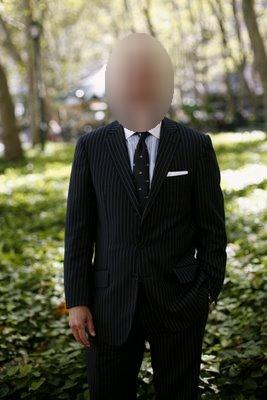

'Ground Truth'

{
  "image_id": "000001",
  "necktie": "yes",
  "collar": "yes",
  "gender": "male",
  "placket": "yes",
  "skin_exposure": "low_exposure",
  "scarf": "no",
  "solid_pattern": "unknown",
  "floral_pattern": "no",
  "spot_pattern": "unknown",
  "graphics_pattern": "no",
  "plaid_pattern": "no",
  "stripe_pattern": "unknown",
  "red": "no",
  "yellow": "no",
  "green": "no",
  "cyan": "no",
  "blue": "no",
  "purple": "no",
  "brown": "no",
  "white": "no",
  "gray": "no",
  "black": "yes",
  "many_colors": "no",
  "sleeve_length": "long_sleeves",
  "neckline": "v_shape",
  "category": "suit"
}

'Grok Extracted Attributes'

{
  "necktie": "yes",
  "collar": "yes",
  "gender": "male",
  "placket": "yes",
  "skin_exposure": "low_exposure",
  "scarf": "no",
  "solid_pattern": "no",
  "floral_pattern": "no",
  "spot_pattern": "no",
  "graphics_pattern": "no",
  "plaid_pattern": "no",
  "stripe_pattern": "yes",
  "red": "no",
  "yellow": "no",
  "green": "no",
  "cyan": "no",
  "blue": "no",
  "purple": "no",
  "brown": "no",
  "white": "no",
  "gray": "no",
  "black": "yes",
  "many_colors": "no",
  "sleeve_length": "long_sleeves",
  "neckline": "other",
  "category": "suit"
}

In [62]:
def show_image_and_extracted_attributes(prompt:str, image_id: str = "000001"):
    image_path = f"{IMAGES_DIR}/{image_id}.jpg"
    img = Image(image_path)

    ground_truth_attributes = get_gt_attributes_by_id(image_id)
    ground_truth_json = json.dumps(ground_truth_attributes, indent=2)

    model_response = analyze_image(prompt, image_path)
    extracted_attributes_json = extract_json_from_xml(model_response)
    extracted_attributes_json_str = json.dumps(extracted_attributes_json, indent=2)

    display(img)
    display("Ground Truth")
    display(Code(ground_truth_json, language='json'))

    display("Grok Extracted Attributes")
    display(Code(extracted_attributes_json_str, language='json'))


show_image_and_extracted_attributes(attribute_extraction_prompt)

Ok nice, looks like we're getting back some similar data. However, let's be more scientific about our evaluation approach and write some proper evaluation code. We will run the prompt above on a batch of images and then compare the attributes Grok extracted with the ground truth attributes. This will quantify how accurately Grok identifies each attribute and highlight which ones present challenges or yield inconsistent results.

## Evals <a name="evals"></a>

The full dataset contains 1856 images, but for this cookbook will process only 250. Let's leverage the Async API to concurrently process images speeding up our extraction process.

### Using the Async API to Batch Process Images <a name="using-the-async-api-to-batch-process-images"></a>

First let's write an async version of our `analyze_image` function which will leverage an instance of the `AsyncOpenAI` client. We can then call this function concurrently using `asyncio` to minimize the time taken to process a large batch of images.

In [63]:
from openai import AsyncOpenAI


async def analyze_image_async(client: AsyncOpenAI, prompt: str, image_id: str) -> dict[str, str]:
    image_path = f"{IMAGES_DIR}/{image_id}.jpg"

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{base64_encode_image(image_path)}"
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]

    completion = await client.chat.completions.create(
        model=GROK_VISION_MODEL,
        messages=messages
    )

    if not completion.choices[0].message.content:
        raise ValueError("Expected message content on response was not found")

     # Add the image_id back to the predicted attributes for easier identification later
    image_id = image_path.removeprefix(f"{IMAGES_DIR}/").removesuffix(".jpg")

    try:
        json_result = extract_json_from_xml(completion.choices[0].message.content)
        json_result["image_id"] = image_id
    except Exception:
        print(f"Failed to parse valid JSON for image with id: {image_id}")
        print(f"Response from Grok: {completion.choices[0].message.content}")
        json_result = {"image_id": image_id}

    return json_result

Lets run our new async function with a single image to make sure working.

In [64]:
async_grok_client = AsyncOpenAI(
    api_key=XAI_API_KEY,
    base_url=BASE_URL
)

await analyze_image_async(async_grok_client, attribute_extraction_prompt, "000001")

{'necktie': 'yes',
 'collar': 'yes',
 'gender': 'male',
 'placket': 'no',
 'skin_exposure': 'low_exposure',
 'scarf': 'no',
 'solid_pattern': 'no',
 'floral_pattern': 'no',
 'spot_pattern': 'no',
 'graphics_pattern': 'no',
 'plaid_pattern': 'no',
 'stripe_pattern': 'yes',
 'red': 'no',
 'yellow': 'no',
 'green': 'no',
 'cyan': 'no',
 'blue': 'no',
 'purple': 'no',
 'brown': 'no',
 'white': 'no',
 'gray': 'no',
 'black': 'yes',
 'many_colors': 'no',
 'sleeve_length': 'long_sleeves',
 'neckline': 'other',
 'category': 'suit',
 'image_id': '000001'}

Let's create a function using our new async method to batch-process images, with a `max_in_flight_requests` parameter to cap concurrent requests. You should tune this to match your tier’s rate limits, which you can view via the model's page on the [xAI console](https://console.x.ai) both for `grok-2-vision` as well as other models.

In [ ]:
import asyncio
from tqdm.asyncio import tqdm


async def analyze_batch(client: AsyncOpenAI, image_ids: list[str], analysis_prompt: str, max_in_flight_requests = 10) -> list[dict[str, str]]:
    semaphore = asyncio.Semaphore(max_in_flight_requests)

    async def analyze_with_semaphore(image_id: str) -> dict:
        async with semaphore:
            result = await analyze_image_async(client, analysis_prompt, image_id)
            return result

    tasks = [analyze_with_semaphore(image_id) for image_id in image_ids]
    results = []
    for task in tqdm.as_completed(tasks, total=len(tasks), desc="Analyzing images"):
        result = await task
        results.append(result)
    return results

In [25]:
from pathlib import Path

image_ids = [image_path.stem for image_path in sorted(Path(IMAGES_DIR).glob("*.jpg"))]
image_ids_subset = image_ids[:250]

grok_predictions = await analyze_batch(async_grok_client, image_ids_subset, attribute_extraction_prompt, max_in_flight_requests=5)

Analyzing images:   0%|          | 0/250 [00:00<?, ?it/s]

Analyzing images: 100%|██████████| 250/250 [00:27<00:00,  9.11it/s]


In [26]:
valid_grok_predictions = []
invalid_grok_predictions = []
for prediction in grok_predictions:
    if len(prediction.keys()) == 1: # this means the JSON parsing was not successful, ignore from the result set
        invalid_grok_predictions.append(prediction["image_id"])
    else:
        valid_grok_predictions.append(prediction)

if len(invalid_grok_predictions) > 0:
    print(f"Failed to extract valid JSON for images with IDs: {invalid_grok_predictions}, excluding from result set")
else:
    print("All images analyzed successfully")

valid_grok_predictions.sort(key=lambda prediction: prediction["image_id"])

All images analyzed successfully


### Calculating our Evaluation Metrics <a name="calculating-our-evaluation-metrics"></a>

Now that we've gathered our extracted attributes using Grok (our predictions), we'll compare them against the ground truth attributes from our dataset and calculate metrics like [accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score), [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#precision-score), [recall](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) and [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). We'll also show the [confusion matrices](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) for each attribute. Finally, if there was a mismatch we'll print the ID of the image and the difference between Grok's prediction and the ground truth label so we can investigate that particular image, attribute pair further.

> **Note:** The metrics calculation below excludes comparison/calculation for ground truth attributes that have a label value of "unknown". In the code below, valid samples for a given attribute are those which have a label which is not "unknown"

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

valid_prediction_ids = [p["image_id"] for p in valid_grok_predictions]
ground_truths = [g for g in ground_truth_attributes if g["image_id"] in valid_prediction_ids]

BINARY_ATTRIBUTES = [
    "necktie",
    "collar",
    "gender",
    "placket",
    "scarf",
    "floral_pattern",
    "graphics_pattern",
    "plaid_pattern",
    "many_colors",
    "red", "yellow", "green", "cyan", "blue", "purple", "brown", "white", "gray", "black",
]

MULTI_CLASS_ATTRIBUTES = ["sleeve_length", "neckline", "category"]

COMPUTED_METRICS = {"binary": {}, "multi_class": {}}
MISMATCHES = {"binary": {}, "multi_class": {}}  # New dictionary to store mismatches

def preprocess_binary(data_list: list[dict[str, str]], attribute: str):
    """Preprocess binary attributes (yes/no or male/female) to 0/1, return labels and validity mask."""
    labels = [item[attribute] for item in data_list]
    if attribute == "gender":
        processed = [1 if x == "male" else 0 if x == "female" else -1 for x in labels]  # -1 for unknown
    else:
        processed = [1 if x == "yes" else 0 if x == "no" else -1 for x in labels]  # -1 for unknown
    return processed

def preprocess_multi_class(data_list: list[dict[str, str]], attribute: str):
    """Preprocess multi class attributes to integers and return label mapping."""
    labels = [item[attribute] for item in data_list]
    unique_values = list(set(labels) - {"unknown"})  # Exclude "unknown"
    if not unique_values:  # Handle case where all are "unknown"
        unique_values = ["unknown"]
    value_to_int = {val: idx for idx, val in enumerate(unique_values)}
    processed_labels = [value_to_int.get(x, -1) for x in labels]  # -1 for unknown
    return processed_labels, unique_values

def capture_mismatches(attribute, y_true, y_pred, actual_data, predicted_data, mask, is_binary=True):
    """Capture mismatches in a list of tuples (image_id, actual, predicted) for the given attribute."""
    mismatch_list = []
    for idx, orig_idx in enumerate(mask):  # Use mask to map back to original indices
        if y_true[idx] != y_pred[idx]:  # Check for mismatch in filtered data
            image_id = actual_data[orig_idx]["image_id"]
            if is_binary:
                if attribute == "gender":
                    actual_val = "male" if y_true[idx] == 1 else "female"
                    pred_val = "male" if y_pred[idx] == 1 else "female"
                else:
                    actual_val = "yes" if y_true[idx] == 1 else "no"
                    pred_val = "yes" if y_pred[idx] == 1 else "no"
            else:
                # For multiclass, use the original string values
                all_labels = list(set([actual_data[i][attribute] for i in range(len(actual_data))] +
                                    [predicted_data[i][attribute] for i in range(len(predicted_data))]) - {"unknown"})
                value_to_int = {val: idx for idx, val in enumerate(all_labels)}
                int_to_value = {idx: val for val, idx in value_to_int.items()}
                actual_val = int_to_value[y_true[idx]]
                pred_val = int_to_value[y_pred[idx]]
            mismatch_list.append((image_id, actual_val, pred_val))
    return mismatch_list

for attribute in BINARY_ATTRIBUTES:
    y_true = preprocess_binary(ground_truths, attribute)
    y_pred = preprocess_binary(valid_grok_predictions, attribute)

    # Filter out samples where either y_true or y_pred is "unknown" (-1)
    mask = [i for i in range(len(y_true)) if y_true[i] != -1 and y_pred[i] != -1]
    y_true_filtered = np.array(y_true)[mask]
    y_pred_filtered = np.array(y_pred)[mask]

    if len(y_true_filtered) > 0:
        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, average='binary', pos_label=1)
        recall = recall_score(y_true_filtered, y_pred_filtered, average='binary', pos_label=1)
        f1 = f1_score(y_true_filtered, y_pred_filtered, average='binary', pos_label=1)
        conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

        COMPUTED_METRICS["binary"][attribute] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

        print(f"\nMetrics for binary attribute: {attribute}")
        print(f"Valid samples: {len(y_true_filtered)}/{len(y_true)}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print("Confusion Matrix:")
        print(conf_matrix)

        MISMATCHES["binary"][attribute] = capture_mismatches(attribute, y_true_filtered, y_pred_filtered, ground_truths, valid_grok_predictions, mask, is_binary=True)
    else:
        print(f"No valid data for binary attribute: {attribute} (all samples excluded due to 'unknown')")
        MISMATCHES["binary"][attribute] = []  # Empty list if no valid data

for attribute in MULTI_CLASS_ATTRIBUTES:
    y_true, true_labels = preprocess_multi_class(ground_truths, attribute)
    y_pred, pred_labels = preprocess_multi_class(valid_grok_predictions, attribute)

    # Ensure labels match (use the union of both sets for consistency)
    all_labels = list(set(true_labels + pred_labels))
    value_to_int = {val: idx for idx, val in enumerate(all_labels)}
    y_true_final = [value_to_int.get(x, -1) for x in [ground_truths[i][attribute] for i in range(len(ground_truths))]]
    y_pred_final = [value_to_int.get(x, -1) for x in [valid_grok_predictions[i][attribute] for i in range(len(valid_grok_predictions))]]

    # Filter out -1 (unknown) if any
    mask = [i for i in range(len(y_true_final)) if y_true_final[i] != -1 and y_pred_final[i] != -1]
    y_true_final = np.array(y_true_final)[mask]
    y_pred_final = np.array(y_pred_final)[mask]

    if len(y_true_final) > 0:
        accuracy = accuracy_score(y_true_final, y_pred_final)
        precision = precision_score(y_true_final, y_pred_final, average='weighted')
        recall = recall_score(y_true_final, y_pred_final, average='weighted')
        f1 = f1_score(y_true_final, y_pred_final, average='weighted')
        conf_matrix = confusion_matrix(y_true_final, y_pred_final)

        COMPUTED_METRICS["multi_class"][attribute] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

        print(f"\nMetrics for multi class attribute: {attribute}")
        print(f"Valid samples: {len(y_true_final)}/{len(y_true)}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print("Confusion Matrix:")
        print(conf_matrix)

        MISMATCHES["multi_class"][attribute] = capture_mismatches(attribute, y_true_final, y_pred_final, ground_truths, valid_grok_predictions, mask, is_binary=False)
    else:
        print(f"No valid data for multi class attribute: {attribute} (all samples excluded due to 'unknown')")
        MISMATCHES["multi_class"][attribute] = []  # Empty list if no valid data


Metrics for binary attribute: necktie
Valid samples: 227/250
Accuracy: 0.947136563876652
Precision: 0.7777777777777778
Recall: 1.0
F1-Score: 0.875
Confusion Matrix:
[[173  12]
 [  0  42]]

Metrics for binary attribute: collar
Valid samples: 203/250
Accuracy: 0.9261083743842364
Precision: 0.9473684210526315
Recall: 0.9536423841059603
F1-Score: 0.9504950495049505
Confusion Matrix:
[[ 44   8]
 [  7 144]]

Metrics for binary attribute: gender
Valid samples: 243/250
Accuracy: 0.9547325102880658
Precision: 0.9541984732824428
Recall: 0.9615384615384616
F1-Score: 0.9578544061302682
Confusion Matrix:
[[107   6]
 [  5 125]]

Metrics for binary attribute: placket
Valid samples: 250/250
Accuracy: 0.604
Precision: 0.945054945054945
Recall: 0.4777777777777778
F1-Score: 0.6346863468634686
Confusion Matrix:
[[65  5]
 [94 86]]

Metrics for binary attribute: scarf
Valid samples: 219/250
Accuracy: 0.9269406392694064
Precision: 0.7142857142857143
Recall: 0.7142857142857143
F1-Score: 0.7142857142857143
Co

Grok performs impressively on the majority of attributes, achieving high accuracy on gender, sleeve length, and necktie detection, demonstrating its strength in clear, distinct visual features. However, Grok does not perform as well on more ambiguous or complex attributes like placket and neckline. Let’s dive into some of the images where Grok’s predictions differ from the ground truth.

### Error Analysis and Looking at our Data <a name="error-analysis-and-looking-at-our-data"></a>

Despite scoring strongly on Gender, there a still a few images where Grok's prediction differed from the ground truth. Let's have a look at some of those images.

In [28]:
for (image_id, ground_truth_gender, predicted_gender) in MISMATCHES["binary"]["gender"]:
    print(f"Image ID: {image_id}, Actual: {ground_truth_gender}, Predicted: {predicted_gender}")

Image ID: 000027, Actual: male, Predicted: female
Image ID: 000029, Actual: male, Predicted: female
Image ID: 000077, Actual: female, Predicted: male
Image ID: 000104, Actual: female, Predicted: male
Image ID: 000105, Actual: female, Predicted: male
Image ID: 000120, Actual: male, Predicted: female
Image ID: 000137, Actual: male, Predicted: female
Image ID: 000144, Actual: male, Predicted: female
Image ID: 000155, Actual: female, Predicted: male
Image ID: 000160, Actual: female, Predicted: male
Image ID: 000198, Actual: female, Predicted: male


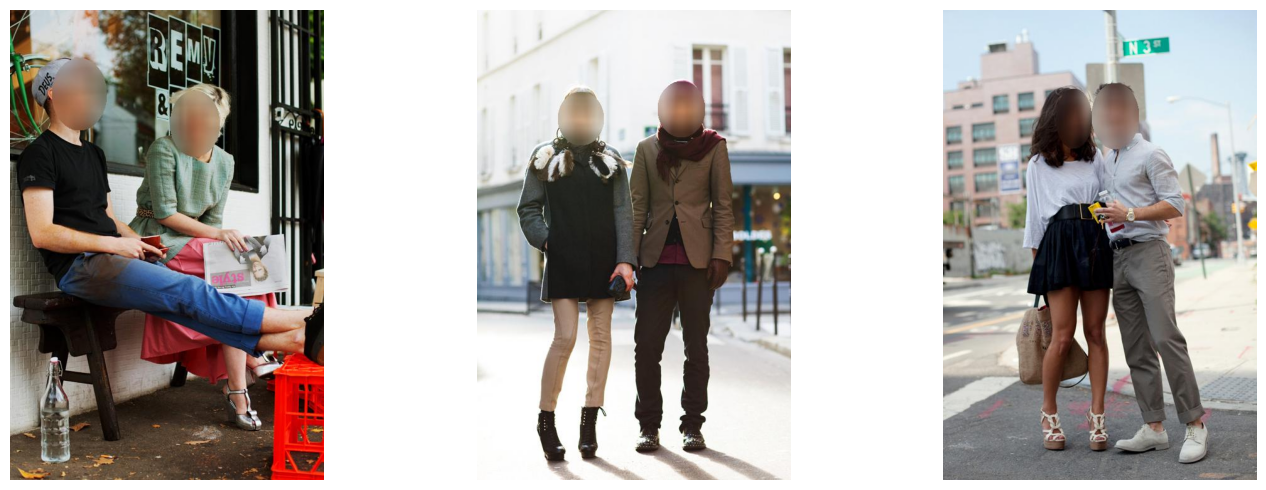

In [68]:
import matplotlib.image as mpimg

image_paths = [
    f"{IMAGES_DIR}/000104.jpg",
    f"{IMAGES_DIR}/000137.jpg",
    f"{IMAGES_DIR}/000144.jpg",
]

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Aha! We can see that in these images both genders are in the photo, however the schema we asked Grok to use only specifies one gender. So it makes sense why Grok's predictions differed from the ground truth label, since it simply picked the opposing gender from the ground truth label. So it's not that Grok was wrong per se, its more the case that we made some assumptions (only one gender per photo) with our data schema that turned out to be false.

Let's do this for some of the other attributes where we saw lower accuracy such as the neckline attribute.

In [30]:
for (image_id, ground_truth_neckline, predicted_neckline) in MISMATCHES["multi_class"]["neckline"]:
    print(f"Image ID: {image_id}, Actual: {ground_truth_neckline}, Predicted: {predicted_neckline}")

Image ID: 000001, Actual: v_shape, Predicted: other
Image ID: 000007, Actual: v_shape, Predicted: other
Image ID: 000008, Actual: round, Predicted: other
Image ID: 000009, Actual: v_shape, Predicted: other
Image ID: 000010, Actual: v_shape, Predicted: other
Image ID: 000012, Actual: v_shape, Predicted: other
Image ID: 000014, Actual: v_shape, Predicted: other
Image ID: 000015, Actual: v_shape, Predicted: other
Image ID: 000016, Actual: round, Predicted: other
Image ID: 000018, Actual: v_shape, Predicted: other
Image ID: 000021, Actual: v_shape, Predicted: other
Image ID: 000026, Actual: other, Predicted: round
Image ID: 000028, Actual: v_shape, Predicted: round
Image ID: 000029, Actual: v_shape, Predicted: other
Image ID: 000033, Actual: v_shape, Predicted: other
Image ID: 000034, Actual: round, Predicted: other
Image ID: 000037, Actual: v_shape, Predicted: other
Image ID: 000039, Actual: v_shape, Predicted: other
Image ID: 000040, Actual: round, Predicted: other
Image ID: 000042, Actu

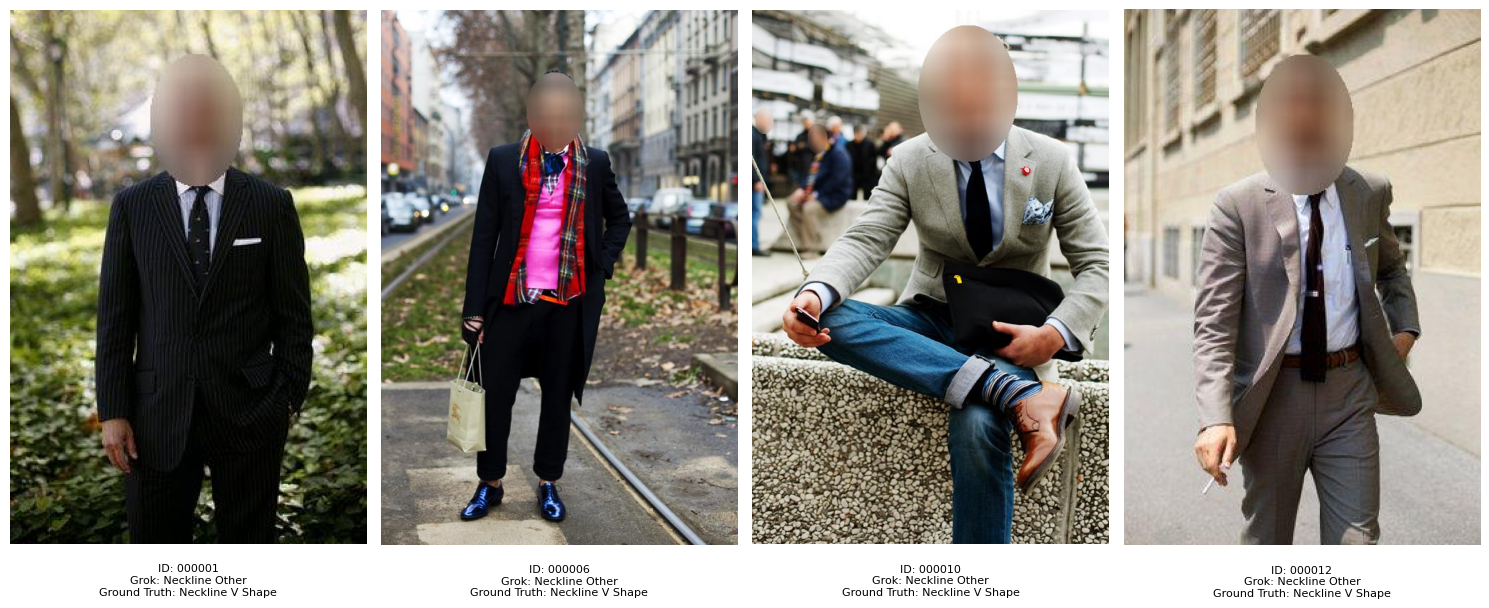

In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_paths = [
    f"{IMAGES_DIR}/000001.jpg",
    f"{IMAGES_DIR}/000006.jpg",
    f"{IMAGES_DIR}/000010.jpg",
    f"{IMAGES_DIR}/000012.jpg",
]

labels = [
    {"image_id":"000001", "actual": "v_shape", "predicted": "other"},
    {"image_id":"000006", "actual": "v_shape", "predicted": "other"},
    {"image_id":"000010", "actual": "v_shape", "predicted": "other"},
    {"image_id":"000012", "actual": "v_shape", "predicted": "other"},
]


fig, axes = plt.subplots(1, 4, figsize=(15, 10))


axes = axes.flatten()


for ax, img_path, label in zip(axes, image_paths, labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    
    label_text = f"ID: {label["image_id"]}\n" \
                f"Grok: Neckline {label['predicted'].replace('_', ' ').title()}\n" \
                f"Ground Truth: Neckline {label['actual'].replace('_', ' ').title()}"
    
    
    ax.set_title(label_text, pad=5, fontsize=8, verticalalignment='top', y=-0.05)


plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

For this guide, all images have been processed with face blur to preserve privacy, a step not present in the original Clothing Attributes Dataset, where faces are visible. This face blur often occludes the neckline area, making it harder for Grok to accurately identify shapes like V-neck or round necklines, especially when subjects are distant or the neckline is partially obscured by posture or collars. If we look at images such as 10 and 12 we can see that the face blur indeed occludes the neckline, most likely interfering with Grok's ability to accurately categorize it.

Let's compare mismatches for some of the color attributes where we saw lower performance to see if we can uncover any other insights.

In [32]:
for (image_id, actual, predicted) in MISMATCHES["binary"]["red"]:
    print(f"Image ID: {image_id}, Actual: {actual}, Predicted: {predicted}")

Image ID: 000006, Actual: no, Predicted: yes
Image ID: 000013, Actual: no, Predicted: yes
Image ID: 000020, Actual: no, Predicted: yes
Image ID: 000021, Actual: no, Predicted: yes
Image ID: 000022, Actual: no, Predicted: yes
Image ID: 000024, Actual: no, Predicted: yes
Image ID: 000034, Actual: no, Predicted: yes
Image ID: 000036, Actual: no, Predicted: yes
Image ID: 000046, Actual: no, Predicted: yes
Image ID: 000079, Actual: no, Predicted: yes
Image ID: 000083, Actual: no, Predicted: yes
Image ID: 000089, Actual: no, Predicted: yes
Image ID: 000095, Actual: no, Predicted: yes
Image ID: 000103, Actual: no, Predicted: yes
Image ID: 000120, Actual: no, Predicted: yes
Image ID: 000126, Actual: no, Predicted: yes
Image ID: 000128, Actual: no, Predicted: yes
Image ID: 000134, Actual: no, Predicted: yes
Image ID: 000135, Actual: no, Predicted: yes
Image ID: 000150, Actual: no, Predicted: yes
Image ID: 000153, Actual: no, Predicted: yes
Image ID: 000162, Actual: no, Predicted: yes
Image ID: 

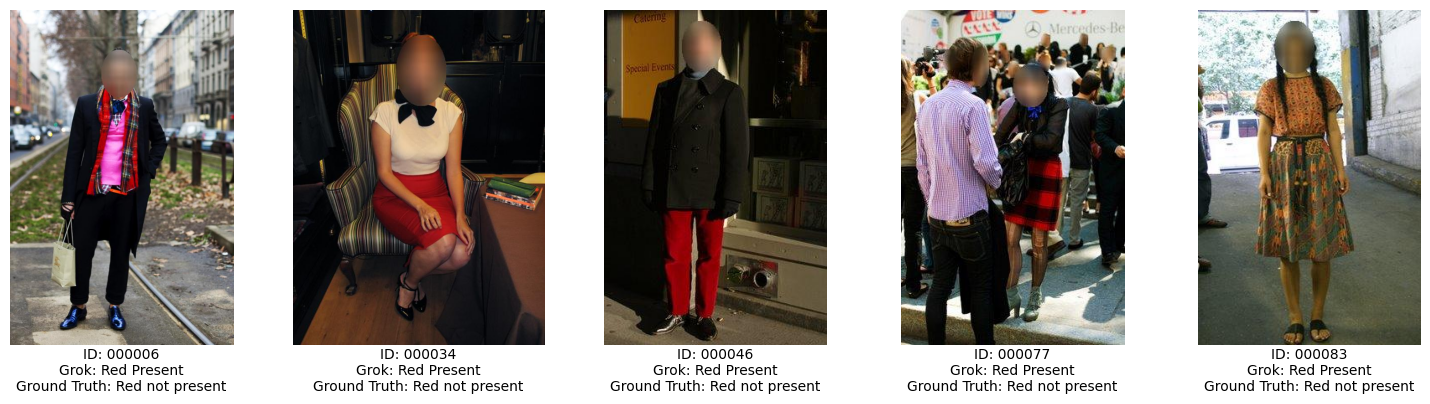

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_paths = [
    f"{IMAGES_DIR}/000006.jpg",
    f"{IMAGES_DIR}/000034.jpg",
    f"{IMAGES_DIR}/000046.jpg",
    f"{IMAGES_DIR}/000077.jpg",
    f"{IMAGES_DIR}/000083.jpg",
]

labels = [
    {"id": "000006", "predicted": "Red Present", "actual": "Red not present"},
    {"id": "000034", "predicted": "Red Present", "actual": "Red not present"},
    {"id": "000046", "predicted": "Red Present", "actual": "Red not present"},
    {"id": "000077", "predicted": "Red Present", "actual": "Red not present"},
    {"id": "000083", "predicted": "Red Present", "actual": "Red not present"},
]

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path, label in zip(axes, image_paths, labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    
    label_text = f"ID: {label['id']}\n" \
                f"Grok: {label['predicted']}\n" \
                f"Ground Truth: {label['actual']}"
    
    ax.set_title(label_text, pad=10, fontsize=10, verticalalignment='top', y=-0.05)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

The images above are cases where Grok predicted the color red as being present in the image where the ground truth labels did not. What is common across these images is that color red **does** appear in all the images, however it is **not** the color of the primary or central piece of clothing. For example, the scarf of the man in the first image - this could lead us to assume that perhaps the human labelers had specific instructions to only label colors of primary objects of clothing. So actually in this case Grok is doing a good job, since all these images do indeed contain red.

Finally, let's do the same for the color blue.

In [34]:
for (image_id, actual, predicted) in MISMATCHES["binary"]["blue"]:
    print(f"Image ID: {image_id}, Actual: {actual}, Predicted: {predicted}")

Image ID: 000002, Actual: no, Predicted: yes
Image ID: 000006, Actual: no, Predicted: yes
Image ID: 000010, Actual: no, Predicted: yes
Image ID: 000027, Actual: no, Predicted: yes
Image ID: 000035, Actual: no, Predicted: yes
Image ID: 000037, Actual: no, Predicted: yes
Image ID: 000041, Actual: no, Predicted: yes
Image ID: 000047, Actual: no, Predicted: yes
Image ID: 000049, Actual: no, Predicted: yes
Image ID: 000054, Actual: no, Predicted: yes
Image ID: 000056, Actual: no, Predicted: yes
Image ID: 000057, Actual: no, Predicted: yes
Image ID: 000064, Actual: no, Predicted: yes
Image ID: 000069, Actual: no, Predicted: yes
Image ID: 000074, Actual: no, Predicted: yes
Image ID: 000077, Actual: no, Predicted: yes
Image ID: 000078, Actual: no, Predicted: yes
Image ID: 000079, Actual: no, Predicted: yes
Image ID: 000084, Actual: no, Predicted: yes
Image ID: 000085, Actual: no, Predicted: yes
Image ID: 000086, Actual: no, Predicted: yes
Image ID: 000087, Actual: no, Predicted: yes
Image ID: 

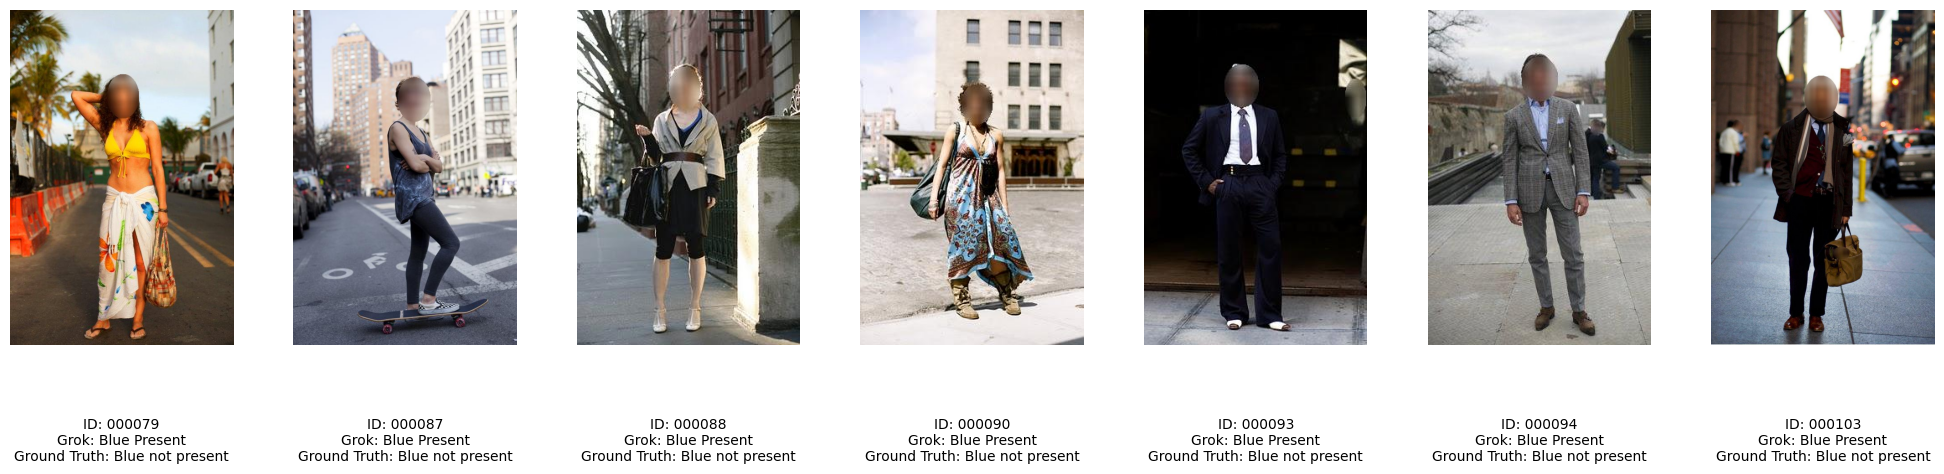

In [52]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_paths = [
    f"{IMAGES_DIR}/000079.jpg",
    f"{IMAGES_DIR}/000087.jpg",
    f"{IMAGES_DIR}/000088.jpg",
    f"{IMAGES_DIR}/000090.jpg",
    f"{IMAGES_DIR}/000093.jpg",
    f"{IMAGES_DIR}/000094.jpg",
    f"{IMAGES_DIR}/000103.jpg"
]

labels = [
    {"id": "000079", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000087", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000088", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000090", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000093", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000094", "predicted": "Blue Present", "actual": "Blue not present"},
    {"id": "000103", "predicted": "Blue Present", "actual": "Blue not present"}
]

fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))

for ax, img_path, label in zip(axes, image_paths, labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    
    label_text = f"ID: {label['id']}\n" \
                f"Grok: {label['predicted']}\n" \
                f"Ground Truth: {label['actual']}"
    
    ax.set_title(label_text, pad=20, fontsize=10, verticalalignment='top', y=-0.3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

The images above show cases where Grok detected presence of the color blue, where the ground truth labels did not, in all of these images we can see presence of the color blue (even if its quite minor). This touches on an important detail - it's important that the evals we use to assess model performance are tightly calibrated to the desired outcome in the real world. In this case, since we somewhat retrofitted this online dataset for this cookbook, the ground truth attributes differ to the expectations we had.

The importance of this exercise, manually inspecting our data and comparing discrepancies between actual and expected results, cannot be overstated, especially when deploying GenAI/LLM-powered software in production. This process exposed a naive assumption we had made: that each photo in our dataset would feature only one person. Digging into these failure cases through error analysis is critical. It not only reveals hidden edge cases like multiple people, occlusions etc but also shines a light on flawed assumptions baked into our approach. By systematically studying where and why our system stumbles, we can prioritize fixes, refine our model, prompts and approach to handle real-world complexity, and build more robust, reliable software rather than relying on oversimplified expectations.

So, looking at our data uncovered a few shortcomings of the schema we're using to extract attributes:
1. It doesn't account for multiple people in a single image
2. It doesn't seem to handle multiple colors well
3. It doesn't explicitly define which colors and patterns are attributed to which item of clothing.

Let’s create a custom schema to tackle all these challenges effectively. Our approach will start by designing a custom data schema/model using Pydantic to define a clear structure for our data. Then, we’ll utilize Grok’s structured outputs feature to populate this model based on a natural language response. The process will involve two API calls: first, we’ll use Grok Vision to analyze an image and generate a natural language description with some inherent structure; second, we’ll pass that output to the regular Grok model, which will refine it and format it into our Pydantic model using the structured response capability. This way, we get the flexibility of natural language from the vision analysis and the precision of structured data in the final output. Let’s see how this works in practice.

### Custom Schema Parsing with Pydantic and the Structured Outputs API <a name="custom-schema-parsing-with-pydantic-and-the-structured-outputs-api"></a>

In [36]:
from enum import Enum

from pydantic import BaseModel, Field


class Gender(str, Enum):
    MALE = "male"
    FEMALE = "female"


class Pattern(str, Enum):
    SOLID = "solid"
    FLORAL = "floral"
    SPOT = "spot"
    GRAPHICS = "graphics"
    PLAID = "plaid"
    STRIPE = "stripe"
    OTHER = "other"


class Neckline(str, Enum):
    V_SHAPE = "V-shape"
    ROUND = "Round"
    OTHER_SHAPES = "Other shapes"


class SkinExposure(str, Enum):
    LOW = "low_exposure"
    MODERATE = "moderate_exposure"
    HIGH = "high_exposure"


class SleeveLength(str, Enum):
    NO_SLEEVES = "no_sleeves"
    SHORT_SLEEVE = "short_sleeve"
    LONG_SLEEVE = "long_sleeve"


class AgeGroup(str, Enum):
    CHILD = "child"
    TEEN = "teen"
    ADULT = "adult"
    SENIOR = "senior"


class Posture(str, Enum):
    STANDING = "standing"
    SITTING = "sitting"
    WALKING = "walking"


class ClothingItem(BaseModel):
    name: str = Field(..., description="Type of clothing item (e.g., shirt, pants, necktie)")
    colors: list[str] = Field(..., description="List of colors of the clothing item")
    pattern: Pattern = Field(..., description="Primary pattern of the clothing item")
    sleeve_length: SleeveLength | None = Field(None, description="Length of sleeves, if applicable, set to None if not applicable to item of clothing identified")
    neckline: Neckline | None = Field(None, description="Shape of the neckline, if applicable, set to None if not applicable to item of clothing identified")
    collar: bool | None = Field(None, description="Presence of a collar, set to None if not applicable to item of clothing identified")
    placket: bool | None = Field(None, description="Presence of a placket, set to None if not applicable to item of clothing identified")


class Person(BaseModel):
    gender: Gender = Field(..., description="Gender of the person")
    skin_exposure: SkinExposure = Field(..., description="Overall skin exposure level")
    clothing_items: list[ClothingItem] = Field(..., description="List of clothing items worn")
    age_group: AgeGroup = Field(..., description="Estimated age group of the person")
    posture: Posture = Field(..., description="Physical posture of the person")
    hair_presence: bool = Field(..., description="Whether hair is visible")


class AnnotatedImage(BaseModel):
    persons: list[Person] = Field(..., description="List of people in the image")

The Pydantic model we’ve designed overcomes the limitations of our original schema by providing a more robust and detailed structure. We’ve created a `ClothingItem` model with relevant attributes, enabling finer-grained analysis of individual clothing pieces. Notably, this model supports multiple colors per item, adding flexibility. We’ve also introduced a `Person` model, which links a person to multiple clothing items they’re wearing, also we've introduced some new attributes entirely at the person level such as `age_group`, `posture` and `hair_presence`. Finally, at the top level, we have the `AnnotatedImage` model, which encapsulates one or more people, tying everything together into a comprehensive representation of the image’s content.

In [37]:
multi_person_analysis_prompt = """You are an AI assistant tasked with generating a detailed analysis of clothing attributes and other specified details for each person in a photo that I will provide. Your goal is to examine each person individually, paying close attention to their clothing items and personal characteristics, and present your findings in an organized way.

Follow these steps carefully to complete the task:

1. **Count the People**: Look at the photo and determine how many people are present.

2. **Analyze Clothing Items**: For each person, starting with "Person 1," examine every item of clothing they are wearing making sure to include smaller items/accessiors like hats and scarves. For each clothing item, note the following details:
   - **Type**: What kind of clothing it is (e.g., shirt, pants, dress, skirt, hat, jacket).
   - **Color**: The main color of the item (e.g., blue, red, black).
   - **Pattern**: Any visible pattern (e.g., solid, striped, polka dots, floral), or "none" if there is no pattern.
   - **Extra Details (if applicable)**: If the item is a top (like a shirt or jacket) or a dress, also note:
     - **Sleeve Length**: Options like "sleeveless," "short," "long," or omit if not applicable.
     - **Neckline**: Options like "crew," "v-neck," "scoop," or omit if not applicable.
     - **Collar**: "yes" if a collar is present, "no" if not, or omit if not applicable.
     - **Placket**: "yes" if a placket (a strip with buttons) is present, "no" if not, or omit if not applicable.

3. **Note Personal Attributes**: After listing all clothing items for a person, observe and record these additional details about them:
   - **Gender**: Guess based on appearance as "male," "female," or "unsure" if you can’t tell.
   - **Skin Exposure**: Estimate how much skin is visible as "light" (mostly covered), "moderate" (some skin showing), or "high" (a lot of skin showing).
   - **Age Group**: Estimate their age range as "child" (0-12), "teenager" (13-19), "adult" (20-64), or "senior" (65+).
   - **Posture**: Describe their position, like "standing," "sitting," "walking," or another clear term.
   - **Hair**: Note "yes" if hair is visible on their head, "no" if not.

4. **Present Your Analysis**: Write your findings in a structured XML format, as shown below. Use this exact structure, replacing the placeholders in brackets with what you observe:

<Analysis>
  <Person 1>
    <Clothing>
      <Item>
        <Type>[type]</Type>
        <Color>[color]</Color>
        <Pattern>[pattern]</Pattern>
        <!-- Include these only for tops or dresses, and only if they apply -->
        <Sleeve Length>[sleeve length]</Sleeve Length>
        <Neckline>[neckline]</Neckline>
        <Collar>[yes/no]</Collar>
        <Placket>[yes/no]</Placket>
      </Item>
      <!-- Add more <Item> sections for each additional clothing item -->
    </Clothing>
    <Gender>[gender]</Gender>
    <Skin Exposure>[light/moderate/high]</Skin Exposure>
    <Age Group>[child/teenager/adult/senior]</Age Group>
    <Posture>[posture]</Posture>
    <Hair>[yes/no]</Hair>
  </Person 1>
  <!-- Add more <Person X> sections for each additional person, numbering them sequentially -->
</Analysis>

Tips for the Format:
For each person, number them as "Person 1," "Person 2," and so on.
Include a separate <Item> section for every clothing item you see on that person.
Only include <Sleeve Length>, <Neckline>, <Collar>, or <Placket> tags when they make sense (e.g., for shirts or dresses, not pants).
If you can’t determine an attribute (like gender or age), write "unknown" inside the tag.
Be Thorough: Make sure you don’t miss any clothing items or details that are visible in the photo. Double-check each person to include everything you can see.
By following these steps, you’ll create a clear and detailed analysis that I can easily understand!
"""

In [38]:
async def advanced_extraction(client: AsyncOpenAI, prompt: str, image_id: str) -> AnnotatedImage:
    image_path = f"{IMAGES_DIR}/{image_id}.jpg"

    # The first call made to grok-vision is to extract as much information 
    # but only in a semi-structured way as outlined by our prompt
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{base64_encode_image(image_path)}"
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]

    completion = await client.chat.completions.create(
        model=GROK_VISION_MODEL,
        messages=messages
    )

    if not completion.choices[0].message.content:
        raise ValueError("Expected message content on response was not found")

    semi_structured_response = completion.choices[0].message.content

    print(semi_structured_response)

    # This second call made to grok-2 is to parse our output from the first call into our Pydantic model
    # by leveraging the response_format parameter
    completion = await client.beta.chat.completions.parse(
        model=GROK_MODEL,
        messages=[
            {"role": "user", "content":f"Given the following information about the people in an image and their clothing attributes, extract it into the schema provided: {semi_structured_response}"}
        ],
        response_format=AnnotatedImage,
    )

    structured_response = completion.choices[0].message.parsed

    return structured_response

In [39]:
annotated_image = await advanced_extraction(async_grok_client, multi_person_analysis_prompt, "000104")

Based on the provided image, here is the detailed analysis in the specified XML format:

```xml
<Analysis>
  <Person 1>
    <Clothing>
      <Item>
        <Type>hat</Type>
        <Color>gray</Color>
        <Pattern>solid</Pattern>
      </Item>
      <Item>
        <Type>shirt</Type>
        <Color>black</Color>
        <Pattern>solid</Pattern>
        <Sleeve Length>short</Sleeve Length>
        <Neckline>crew</Neckline>
        <Collar>no</Collar>
        <Placket>no</Placket>
      </Item>
      <Item>
        <Type>pants</Type>
        <Color>blue</Color>
        <Pattern>solid</Pattern>
      </Item>
    </Clothing>
    <Gender>male</Gender>
    <Skin Exposure>moderate</Skin Exposure>
    <Age Group>adult</Age Group>
    <Posture>sitting</Posture>
    <Hair>no</Hair>
  </Person 1>
  <Person 2>
    <Clothing>
      <Item>
        <Type>shirt</Type>
        <Color>green</Color>
        <Pattern>solid</Pattern>
        <Sleeve Length>long</Sleeve Length>
        <Neckline>unknown<

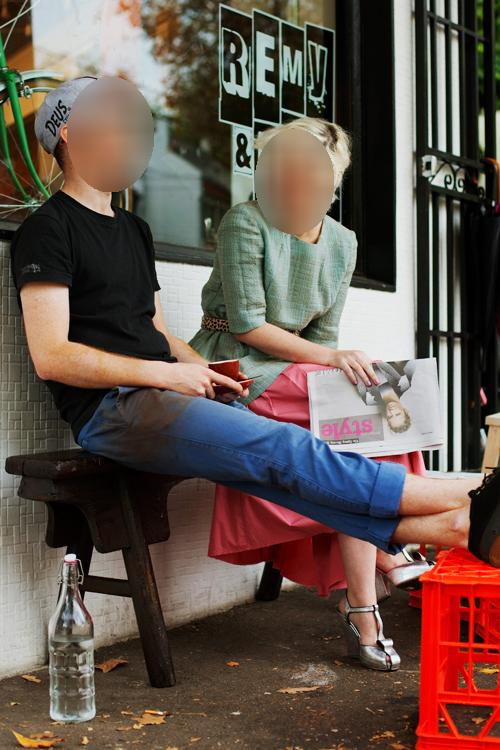

{
  "persons": [
    {
      "gender": "male",
      "skin_exposure": "moderate_exposure",
      "clothing_items": [
        {
          "name": "hat",
          "colors": [
            "gray"
          ],
          "pattern": "solid",
          "sleeve_length": "no_sleeves",
          "neckline": "Other shapes",
          "collar": false,
          "placket": false
        },
        {
          "name": "shirt",
          "colors": [
            "black"
          ],
          "pattern": "solid",
          "sleeve_length": "short_sleeve",
          "neckline": "Round",
          "collar": false,
          "placket": false
        },
        {
          "name": "pants",
          "colors": [
            "blue"
          ],
          "pattern": "solid",
          "sleeve_length": "no_sleeves",
          "neckline": "Other shapes",
          "collar": false,
          "placket": false
        }
      ],
      "age_group": "adult",
      "posture": "sitting",
      "hair_presence": false
    },
    {
      "gender": "female",
      "skin_exposure": "moderate_exposure",
      "clothing_items": [
        {
          "name": "shirt",
          "colors": [
            "green"
          ],
          "pattern": "solid",
          "sleeve_length": "long_sleeve",
          "neckline": "Other shapes",
          "collar": false,
          "placket": false
        },
        {
          "name": "skirt",
          "colors": [
            "pink"
          ],
          "pattern": "solid",
          "sleeve_length": "no_sleeves",
          "neckline": "Other shapes",
          "collar": false,
          "placket": false
        },
        {
          "name": "shoes",
          "colors": [
            "silver"
          ],
          "pattern": "solid",
          "sleeve_length": "no_sleeves",
          "neckline": "Other shapes",
          "collar": false,
          "placket": false
        }
      ],
      "age_group": "adult",
      "posture": "sitting",
      "hair_presence": true
    }
  ]
}

In [40]:
pretty_json = annotated_image.model_dump_json(indent=2)
display(Image(data=f"{IMAGES_DIR}/000104.jpg"))
display(Code(pretty_json, language='json'))

Awesome, Grok successfully identified both subjects in the image along with their gender, clothing details, including colors and patterns at the individual item level. It also accurately extracted our newly added attributes such as posture and age group. It’s impressive to note that we’ve taken an image as input and, in mere seconds, transformed it into a structured, hierarchical Pydantic model. With the data organized in this format, it becomes trivial to execute a variety of downstream tasks, such as saving it to a database, conducting detailed fashion trend analysis, or enabling automated tagging and categorization for further processing.

Since we don't have explicitly labeled data for this new schema, we can't run evals on it without gathering those first. However, we encourage you to test out the flow above on different images to see how it performs, try tweaking the prompt and Pydantic model to see what other cool things you can extract.

### Conclusion <a name="conclusion"></a>

That wraps up our exploration of some powerful tools and techniques in this guide! We’ve walked through using Grok Vision to pull structured data from images, harnessing the `AsyncClient` for efficient processing of many images, and digging into evaluations with ground truth labels to reveal where the model shines, where it stumbles and highlighting edge cases and assumptions about our data. By combining `grok-2-vision` with `grok-2` and structured outputs, we’ve also seen how to shape complex data into custom schemas tailored to your needs.


The xAI team is hard at work improving these capabilities with every update, and we’re excited to see what you’ll build with them. Be sure to check out our [docs page](https://docs.x.ai) for more details on all things related to developing with xAI’s APIs!